In [1]:
import pybamm
import numpy as np
import pandas as pd    # needed to read the csv data file
import matplotlib.pyplot as plt

# Import drive cycle from file
drive_cycle = pd.read_csv("output.csv", comment="#", header=None).to_numpy()


# fig, axs = plt.subplots(2, 1)
# axs[0].plot(drive_cycle[:, 0], drive_cycle[:, 1])
# #axs[0].set_xlim(0, 2)
# axs[0].set_xlabel('time')
# axs[0].set_ylabel('current (A)')
# axs[0].grid(True)

# axs[1].plot(drive_cycle[:, 0], drive_cycle[:, 2])
# #cxy, f = axs[1].cohere(s1, s2, 256, 1. / dt)
# axs[1].set_ylabel('Voltage (V)')

# fig.tight_layout()
# plt.show()


#model = pybamm.lithium_ion.SPMe()
model = pybamm.lithium_ion.DFN()
parameter_values = pybamm.ParameterValues(chemistry=pybamm.parameter_sets.Mohtat2020)
#parameter_values = pybamm.ParameterValues(chemistry=pybamm.parameter_sets.Ai2020)

# Create interpolant
timescale = parameter_values.evaluate(model.timescale)
current_interpolant = pybamm.Interpolant(drive_cycle[:, 0], -drive_cycle[:, 1], timescale * pybamm.t,interpolator="linear")


# c_n_init = self.parameter_values[
#     "Initial concentration in negative electrode [mol.m-3]"
# ]
# c_p_init = self.parameter_values[
#     "Initial concentration in positive electrode [mol.m-3]"
# ]
# param = pybamm.LithiumIonParameters()
# c_n_max = self.parameter_values.evaluate(param.c_n_max)
# c_p_max = self.parameter_values.evaluate(param.c_p_max)
# x, y = pybamm.lithium_ion.get_initial_stoichiometries(
#     initial_soc, self.parameter_values
# )
# self.parameter_values.update(
#     {
#         "Initial concentration in negative electrode [mol.m-3]": x
#         * c_n_max,
#         "Initial concentration in positive electrode [mol.m-3]": y
#         * c_p_max,
#     }
# )
initial_soc=.01
c_n_init = parameter_values[
    "Initial concentration in negative electrode [mol.m-3]"
]
c_p_init = parameter_values[
    "Initial concentration in positive electrode [mol.m-3]"
]
param = pybamm.LithiumIonParameters()
c_n_max = parameter_values.evaluate(param.c_n_max)
c_p_max = parameter_values.evaluate(param.c_p_max)

x, y = pybamm.lithium_ion.get_initial_stoichiometries(
    initial_soc, parameter_values
)
print(x)
print(y)
print(parameter_values["Electrode height [m]"])
print(parameter_values["Electrode width [m]"])
print(parameter_values["Electrode height [m]"]*parameter_values["Electrode width [m]"])

parameter_values.update(
    {
        "Initial concentration in negative electrode [mol.m-3]": x
        * c_n_max,
        "Initial concentration in positive electrode [mol.m-3]": y
        * c_p_max,
    }
)






0.009830469951736854
0.8823213867627666
1.0
0.205
0.205


In [2]:
# Set drive cycle
#parameter_values["Current function [A]"] = current_interpolant
parameter_values["Lower voltage cut-off [V]"] = 2
parameter_values["Upper voltage cut-off [V]"] = 4.2

# load solvers
safe_solver = pybamm.CasadiSolver(atol=1e-6, rtol=1e-6, mode="safe",dt_max=.05)
#scikits_solver=pybamm.ScikitsOdeSolver(method='cvode',atol=1e-6, rtol=1e-9,extrap_tol=0.001)
#model.set_soc_variables(),solver=safe_solver

# get the spatial variables used in pybamm
var = pybamm.standard_spatial_vars  

# create our dictionary 
var_pts = {
    var.x_n: 50,  # negative electrode
    var.x_s: 20,  # separator 
    var.x_p: 50,  # positive electrode
    var.r_n: 100,  # negative particle
    var.r_p: 100,  # positive particle
}

# Define HPPC
experiment = pybamm.Experiment(
    [
        ("Charge at 0.474 A for 720 seconds or until 4.2 V (1 second period)",
        "Rest for 60 seconds (1 second period)",
        "Rest for 1740 seconds (10 second period)",
        "Charge at 2.37 A for 10 seconds or until 4.2 V (0.1 second period)",
        "Rest for 60 seconds (1 second period)",
        "Rest for 540 seconds (10 second period)",
        "Discharge at 2.37 A for 10 seconds (0.1 second period)",
        "Rest for 60 seconds (1 second period)",
        "Rest for 540 seconds (10 second period)"
    ] * 3
)

sim = pybamm.Simulation(model, parameter_values=parameter_values,solver=safe_solver,var_pts=var_pts, experiment=experiment)
#sim.solve(t_eval=drive_cycle[0:200, 0])
sim.solve([0,5000])
sim.plot(["Current [A]", "Terminal voltage [V]",'X-averaged electrolyte overpotential [V]','X-averaged negative electrode reaction overpotential [V]','X-averaged negative electrode potential [V]','X-averaged negative electrode exchange current density [A.m-2]','X-averaged negative particle surface concentration'])

2021-08-25 12:01:58,681 - [WARNING] simulation.solve(744): Ignoring t_eval as solution times are specified by the experiment


interactive(children=(FloatSlider(value=0.0, description='t', max=3.116666666666667, step=0.031166666666666672…

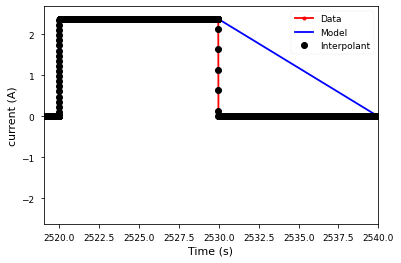

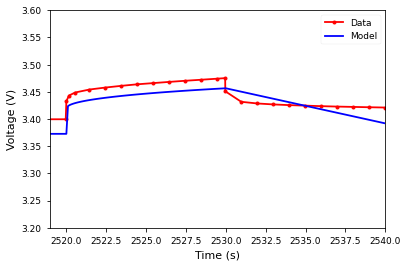

In [3]:
time = sim.solution["Time [s]"].entries
capacity = sim.solution["Discharge capacity [A.h]"](time)
current = -sim.solution["Current [A]"](time)
voltage = sim.solution["Terminal voltage [V]"](time)

current_interpolant = pybamm.Interpolant(drive_cycle[:, 0], -drive_cycle[:, 1], pybamm.t,interpolator="linear")
# timetime=np.linspace(0,10000,100000)
timetime=np.linspace(1799+720,1799+720+21,10000)
timecuurentplot=-current_interpolant.evaluate(timetime)

plt.figure(1)
# plt.scatter(C_rates, capacities)
plt.plot(drive_cycle[:, 0], drive_cycle[:, 1],'.-', label = "Data")
plt.plot(time,current, label = "Model")
plt.plot(timetime,timecuurentplot,'o', label = "interpolant")

plt.xlabel('Time (s)')
plt.ylabel('current (A)')
plt.xlim([0, 15000])
plt.xlim([1799+720,1799+720+21 ])

plt.legend(['Data','Model','Interpolant'])
plt.figure(2)
plt.plot(drive_cycle[:, 0], drive_cycle[:, 2],'.-', label = "Data")
plt.plot(time, voltage)
plt.xlabel("Time (s)")
plt.ylabel("Voltage (V)")
plt.xlim([0, 15000])
plt.xlim([1799+720,1799+720+21 ])
plt.ylim([3.2, 3.6])
plt.legend(['Data','Model'])
plt.show()



# axs[1].plot()
# #cxy, f = axs[1].cohere(s1, s2, 256, 1. / dt)
# axs[1].set_ylabel('Voltage (V)')

# fig.tight_layout()
# plt.show()